<a href="https://colab.research.google.com/github/meg-an31/PubTrends-Data-Insights-for-Enhanced-Paper-Relevance/blob/main/main-colab-file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PubTrends: Data Insights for Enhanced Paper Relevance

To choose the number of clusters the algorithm uses, please input an integer in the box `num_clusters` below.

Also include the file named `PMIDs_list` before running by going to the left hand menu, and selecting **Files → Upload to session storage**.

To run the code, select **Runtime → Run all**.

The final graph will be displayed at the bottom of the page. *I am so sorry about how long it takes to run! eutils limits the number of API calls you can make without a key (and google colab is also hellishly slow).*

In [ ]:
num_clusters = 0 # @param {"type":"integer"}

if num_clusters <= 0:
  raise Exception("Please input a positive integer!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.8 MB/s eta 0:00:00


200116672
200116672
200127893
200127892
200127884
200216999
200137444
200127893
200127892
200127884
200165870
200145669
200145668
200145531
200146026
200118723
200146264
200023694
200076381
200157145
200142259
200140977
200140778
200157027
200156426
200156425
200156424
200080744
200157027
200156426
200156425
200156424
200102248
200088798
200066017
200065685
200054680
200054292
200087162
200197063
200140493
200130711
200097179
200130711
200124391
200040539
200034429
200034427
200034077
200022872
200022870
200022859
200021662
200018178
200018126
200017554
200017554
200072698
200231588
200227741
200183766
200183765
200183764
200183556
200097693
200015745
200028094
200130051
200210256
200210255
200210254
200210256
200210255
200210254
200199806
200214496
200214458
200186357
200215954
200180979
200171017
200171016
200084422
200120584
200120584
200167559
200120584
200033528
200172402
200164788
200127711
200109159
200109158
200105115
200261729
200121750
200243256
200215901
200060202
200060167


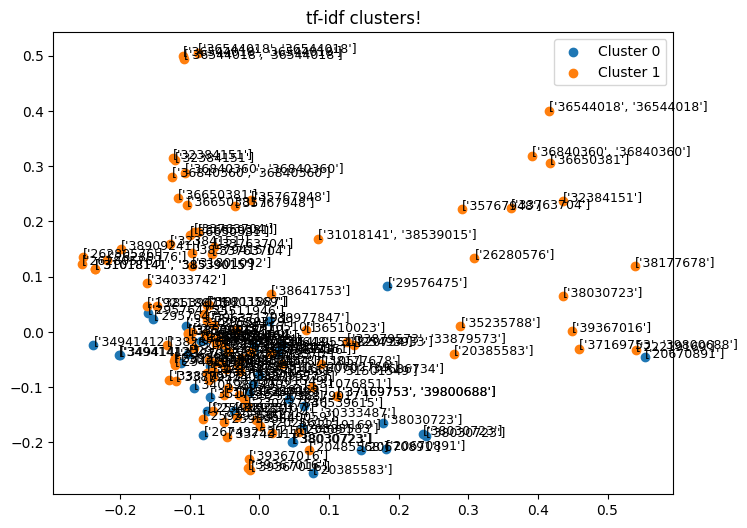

In [1]:
!pip install eutils
from eutils import QueryService
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
import xml.etree.ElementTree as et
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

qs = QueryService()

with open('PMIDs_list.txt') as file:
    pmids = [line.rstrip() for line in file]
#pmids = ['30530648', '31820734']

def fetchAllDBIDs():
    all_ids = {}
    for pmid in pmids:
        # using the eutils library to get the xml doc containing db ids
        xml = qs.elink({'db':'gds', 'dbfrom':'pubmed', 'id':pmid})
        # converting to a xml tree
        root = et.ElementTree(et.fromstring(xml)).getroot()
        # getting all database links contained within the database linkset
        for db in list(root.iter('Link')):
            dbid_temp = list(db.iter('Id'))[0].text
            if not(dbid_temp in list(all_ids.keys())):
                all_ids[dbid_temp] = []
            all_ids[dbid_temp].append(str(pmid))
            #print(dbid_temp)
    return all_ids

def fetchAllDescriptions(dbIDs):
    out = []
    for dbID in dbIDs:
        out.append((str(qs.efetch({'db':'gds', 'id':dbID,}))
                    .replace('\\n',' ').replace('\\t',' ').replace('more...',' ')
                    .replace('(Submitter supplied)',' ').replace('Organism:',' ').replace('Type:',' ').split(
            'Platforms:'))[0])
        #print(out[-1])
    return out

def main():
    # here I am not using an API key, which limits me to 3 requests/second
    allDBIDs = fetchAllDBIDs()
    allDBdescriptions = fetchAllDescriptions(list(allDBIDs.keys()))
    vectoriser = TfidfVectorizer()
    # X is the matrix of all words and their tf-idf values
    X = vectoriser.fit_transform(allDBdescriptions)
    distances = cosine_distances(X)
    # we now have that distances[a][b] gives the distance between database a and b
    # num_clusters is defined above as the user input!
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(X)

    # Labels indicate which cluster each description belongs to
    labels = kmeans.labels_
    print(labels)
    print(X)
    print(vectoriser.get_feature_names_out())

    # in order to visualise what is happening, I flatten the points onto a 2d plane,
    # using the pca algorithm
    pca = PCA(n_components=2)
    points_2d = pca.fit_transform(X.toarray())

    plt.figure(figsize=(8, 6))
    for i in range(num_clusters):
        points = points_2d[labels == i]
        plt.scatter(points[:, 0], points[:, 1], label=f"Cluster {i}")

    plt.title("tf-idf clusters!")
    plt.legend()
    for i, (x, y) in enumerate(points_2d):
        plt.text(x, y, str(list(allDBIDs.values())[i]), fontsize=4)
    plt.show()

if __name__ == '__main__':
    main()